In [1]:
from nilearn import image

# Load power template coords

powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)

print(powerimg.shape)

(91, 109, 91)


In [68]:
import numpy as np

# Load ROI coordinates

import re

# Radius 5
pat = re.compile('.*Power(\d+)([^#]+)#(-?\d+,-?\d+,-?\d+).*')

def parseLine(pat, line):
    res = pat.search(line)
    if res:
        idx, bfn, mni = res.groups()
        mni = np.array([int(coord) for coord in mni.split(',')]+[1])
        return (idx,bfn,mni)
    return None

roifile = '/home/anton/Documents/Tulane/Hackathon/power264/power264CoorMNI.sclib'
rois = []

with open(roifile, 'r') as f:
    for line in f.readlines():
        p = parseLine(pat, line)
        rois.append(p)

rois = [p for p in rois if p is not None]
print(len(rois))

264


In [168]:
print(rois[219])

('220', 'salience', array([-39,  51,  17,   1]))


In [182]:
subfname = 'sub-600009963128_task-rest_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
img = image.load_img(f'/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600009963128/func/{subfname}')

print(img.shape)

(65, 77, 65, 124)


In [183]:
import numpy as np

datimg = image.get_data(img)
datpower = image.get_data(powerimg)

print(datimg.shape)
print(datpower.shape)

(65, 77, 65, 124)
(91, 109, 91)


In [200]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    if (roi == 220):
        print(pcoords[-1])
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

[[42. 50. 50.  1.]
 [42. 50. 51.  1.]
 [42. 50. 52.  1.]
 [42. 51. 50.  1.]
 [42. 51. 51.  1.]
 [42. 51. 52.  1.]
 [42. 52. 50.  1.]
 [42. 52. 51.  1.]
 [42. 52. 52.  1.]
 [43. 49. 50.  1.]
 [43. 49. 51.  1.]
 [43. 49. 52.  1.]
 [43. 50. 49.  1.]
 [43. 50. 50.  1.]
 [43. 50. 51.  1.]
 [43. 50. 52.  1.]
 [43. 50. 53.  1.]
 [43. 51. 49.  1.]
 [43. 51. 50.  1.]
 [43. 51. 51.  1.]
 [43. 51. 52.  1.]
 [43. 51. 53.  1.]
 [43. 52. 49.  1.]
 [43. 52. 50.  1.]
 [43. 52. 51.  1.]
 [43. 52. 52.  1.]
 [43. 52. 53.  1.]
 [43. 53. 50.  1.]
 [43. 53. 51.  1.]
 [43. 53. 52.  1.]
 [44. 49. 50.  1.]
 [44. 49. 51.  1.]
 [44. 49. 52.  1.]
 [44. 50. 49.  1.]
 [44. 50. 50.  1.]
 [44. 50. 51.  1.]
 [44. 50. 52.  1.]
 [44. 50. 53.  1.]
 [44. 51. 49.  1.]
 [44. 51. 50.  1.]
 [44. 51. 51.  1.]
 [44. 51. 52.  1.]
 [44. 51. 53.  1.]
 [44. 52. 49.  1.]
 [44. 52. 50.  1.]
 [44. 52. 51.  1.]
 [44. 52. 52.  1.]
 [44. 52. 53.  1.]
 [44. 53. 50.  1.]
 [44. 53. 51.  1.]
 [44. 53. 52.  1.]
 [45. 49. 50.  1.]
 [45. 49. 51

In [204]:
from scipy.interpolate import interpn

coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
points = [np.arange(s) for s in img.shape[:-1]]
print(coords[:,0:10])

# Test how long
for tp in range(datimg.shape[-1]):
    img0res = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=False)
    
print(img0res[0:10])

[[25.5        25.5        25.5        25.5        25.5        25.5
  25.5        25.5        25.5        24.83333333]
 [10.83333333 10.83333333 10.83333333 11.5        11.5        11.5
  12.16666667 12.16666667 12.16666667 10.16666667]
 [21.5        22.16666667 22.83333333 21.5        22.16666667 22.83333333
  21.5        22.16666667 22.83333333 21.5       ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]]
[958.46442193 955.6575231  948.22839412 971.32619681 922.4495454
 927.18618718 954.32844124 914.37526192 932.30483671 736.69716747]


In [215]:
nt = datimg.shape[-1]
ts = np.zeros((264,nt))
imgres = np.zeros((nt,coords.shape[-1]))

for tp in range(nt):
    imgres[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=False)

for roi in range(264):
    ts[roi] = np.mean(imgres[:,proinums == roi], axis=1)

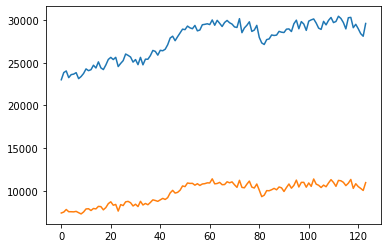

In [214]:
import matplotlib.pyplot as plt

plt.plot(ts[1])
plt.plot(tscheck[1])
plt.show()

In [132]:
import pickle

subtsname = '/run/media/anton/Samsung_T5/data/sub-600009963128-rest.pkl'
tscheck = None

with open(subtsname, 'rb') as f:
    tscheck = pickle.load(f)
    
print(tscheck.shape)

(264, 124)


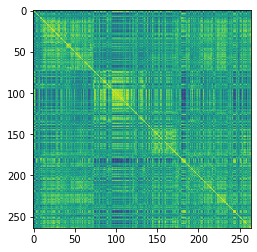

In [216]:
p = np.corrcoef(ts)

plt.imshow(p)
plt.show()

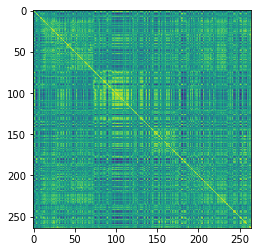

In [219]:
pcheck = np.corrcoef(tscheck)

plt.imshow(pcheck)
plt.show()

In [218]:
np.sum(imgres == 0)

0


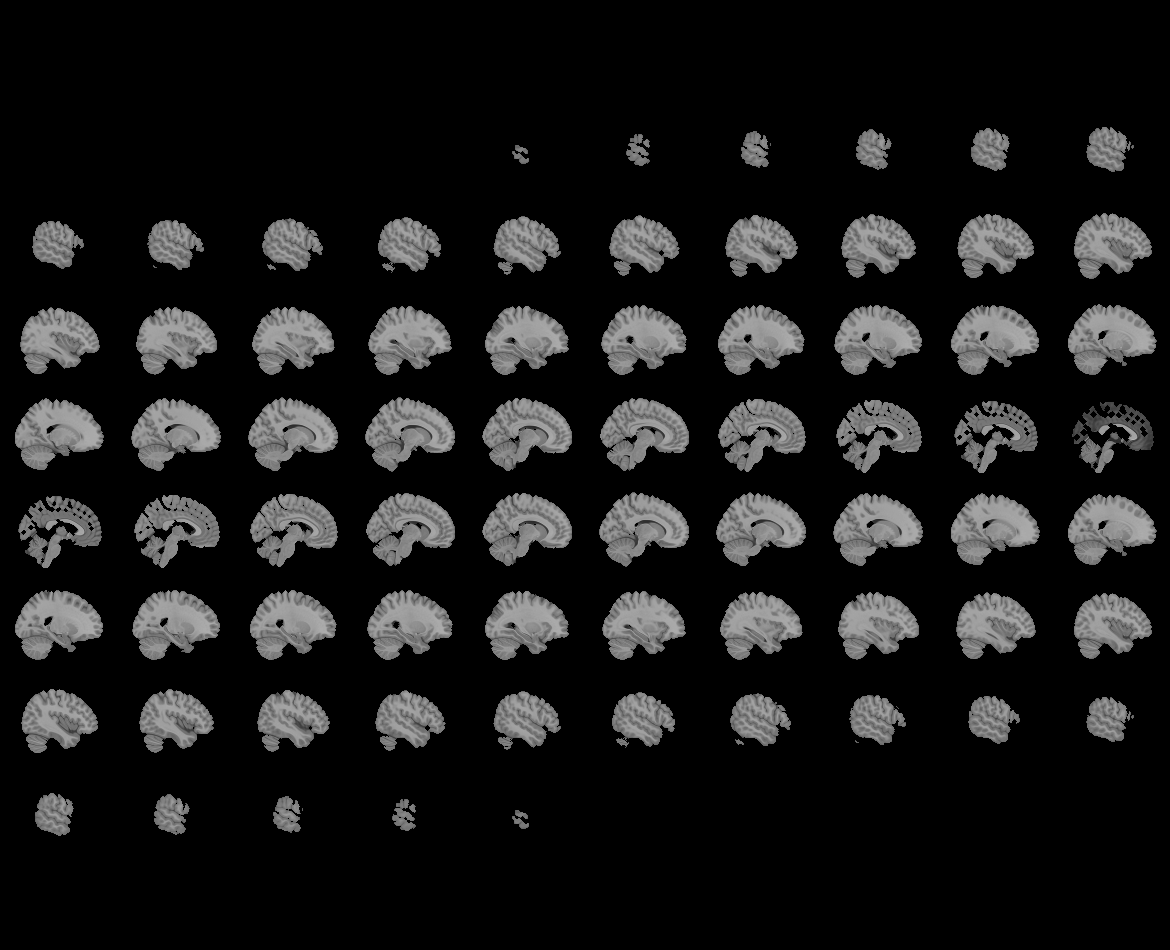
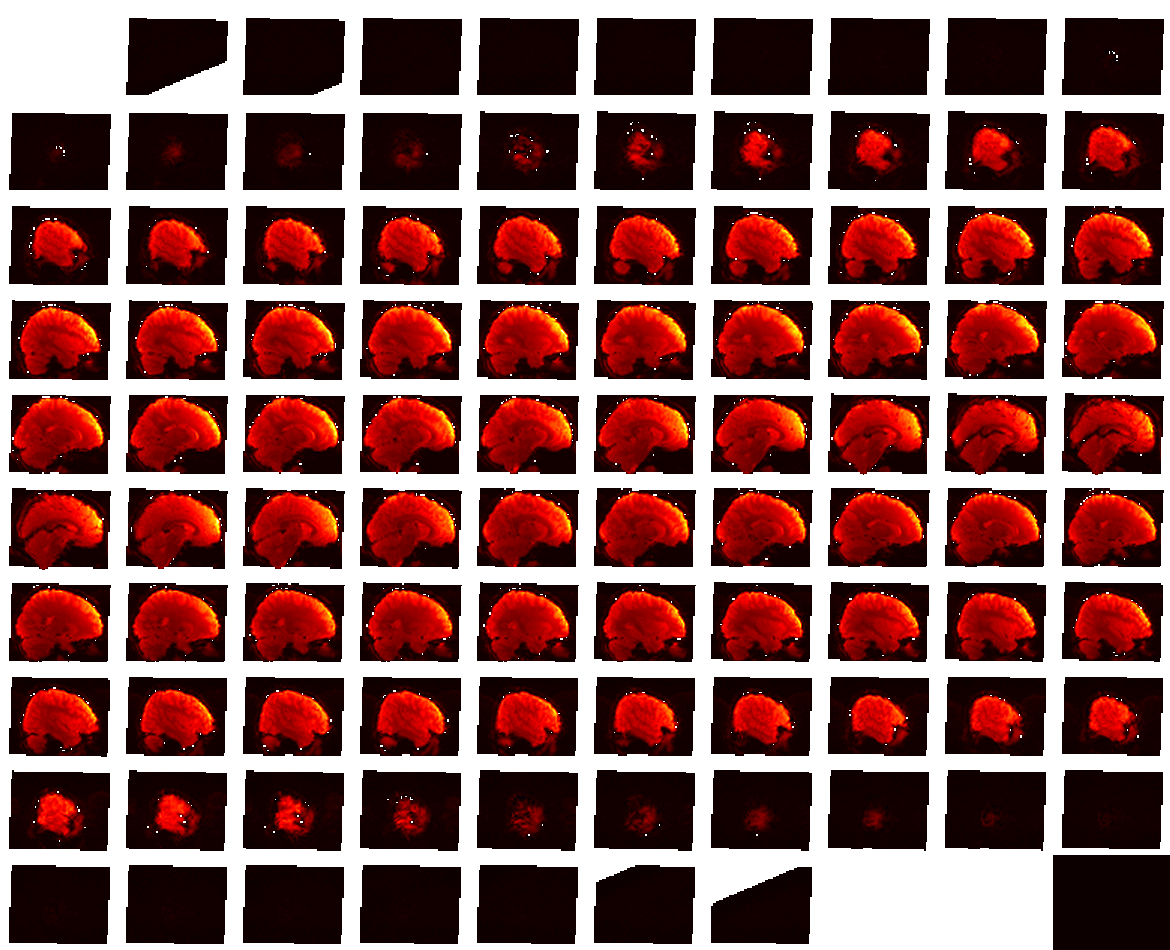

In [169]:
from nilearn import plotting

img0 = image.index_img(img, 0)

plotting.view_img(img0, cut_coords=(-39,51,17))

In [175]:
img.slicer[0:1,0:1,0:1,0:1]

In [188]:
coords[:,proinums == 219][:,0]

array([52.83333333, 73.16666667, 40.5       ,  1.        ])

In [196]:
img.get_data()[19,61,32,1]

/tmp/ipykernel_846880/2127851634.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img.get_data()[19,61,32,1]


2111.03200006485

In [195]:
np.linalg.inv(img.affine)@np.array([-39,51,17,1])

array([19.16666667, 61.16666667, 31.83333333,  1.        ])